In [2]:
### === IMPORTS FOR SIM === ###

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

from doa_sim_methods import run_spacing_vs_frequency_sweep
from doa_sim_methods import plot_2d_heatmap

In [3]:
### === VARIABLE SETUP === ###

sample_rate = 44100
frequencies = np.arange(100, 20001, 500)  # Frequencies from 100 Hz to 20000 Hz
spacings = np.arange(0.01, 0.21, 0.01)  # Spacings from 0.01 m to 0.20 m
angle_range = np.arange(-180, 181, 18)  # Angle range in degrees


In [4]:
### === SIM FUNCTIONS BELOW === ###

results, x, y = run_spacing_vs_frequency_sweep(sample_rate, frequencies, spacings, angle_range)

Running DOA simulation with varying microphone spacing and frequency...
Completed frequency 100 Hz (1/40)
Completed frequency 600 Hz (2/40)
Completed frequency 1100 Hz (3/40)
Completed frequency 1600 Hz (4/40)
Completed frequency 2100 Hz (5/40)
Completed frequency 2600 Hz (6/40)
Completed frequency 3100 Hz (7/40)
Completed frequency 3600 Hz (8/40)
Completed frequency 4100 Hz (9/40)
Completed frequency 4600 Hz (10/40)
Completed frequency 5100 Hz (11/40)
Completed frequency 5600 Hz (12/40)
Completed frequency 6100 Hz (13/40)
Completed frequency 6600 Hz (14/40)
Completed frequency 7100 Hz (15/40)
Completed frequency 7600 Hz (16/40)
Completed frequency 8100 Hz (17/40)
Completed frequency 8600 Hz (18/40)
Completed frequency 9100 Hz (19/40)
Completed frequency 9600 Hz (20/40)
Completed frequency 10100 Hz (21/40)
Completed frequency 10600 Hz (22/40)
Completed frequency 11100 Hz (23/40)
Completed frequency 11600 Hz (24/40)
Completed frequency 12100 Hz (25/40)
Completed frequency 12600 Hz (26/4

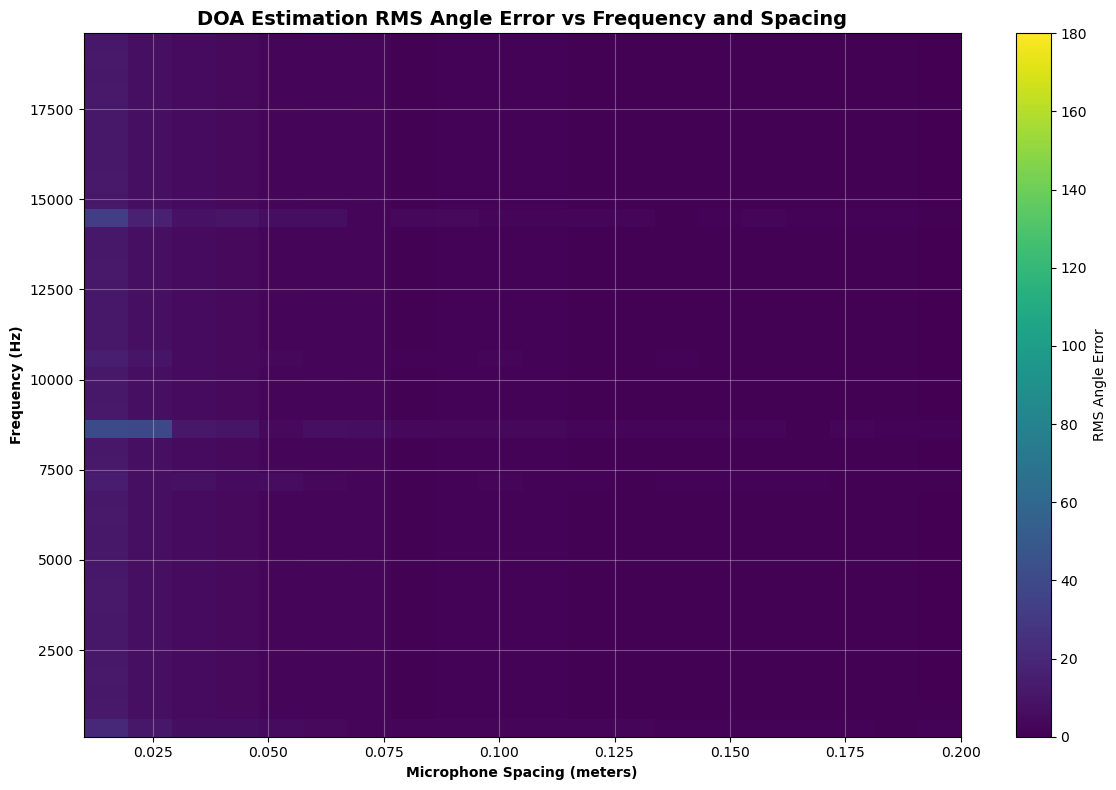

In [5]:
plot_2d_heatmap(results, x, y, vmin=0, vmax=180)